In [ ]:
# !pip install pandas numpy matplotlib statsmodels scikit-learn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

# Required Libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM


C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\954966018.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gold_data['date'] = pd.to_datetime(gold_data['date'])


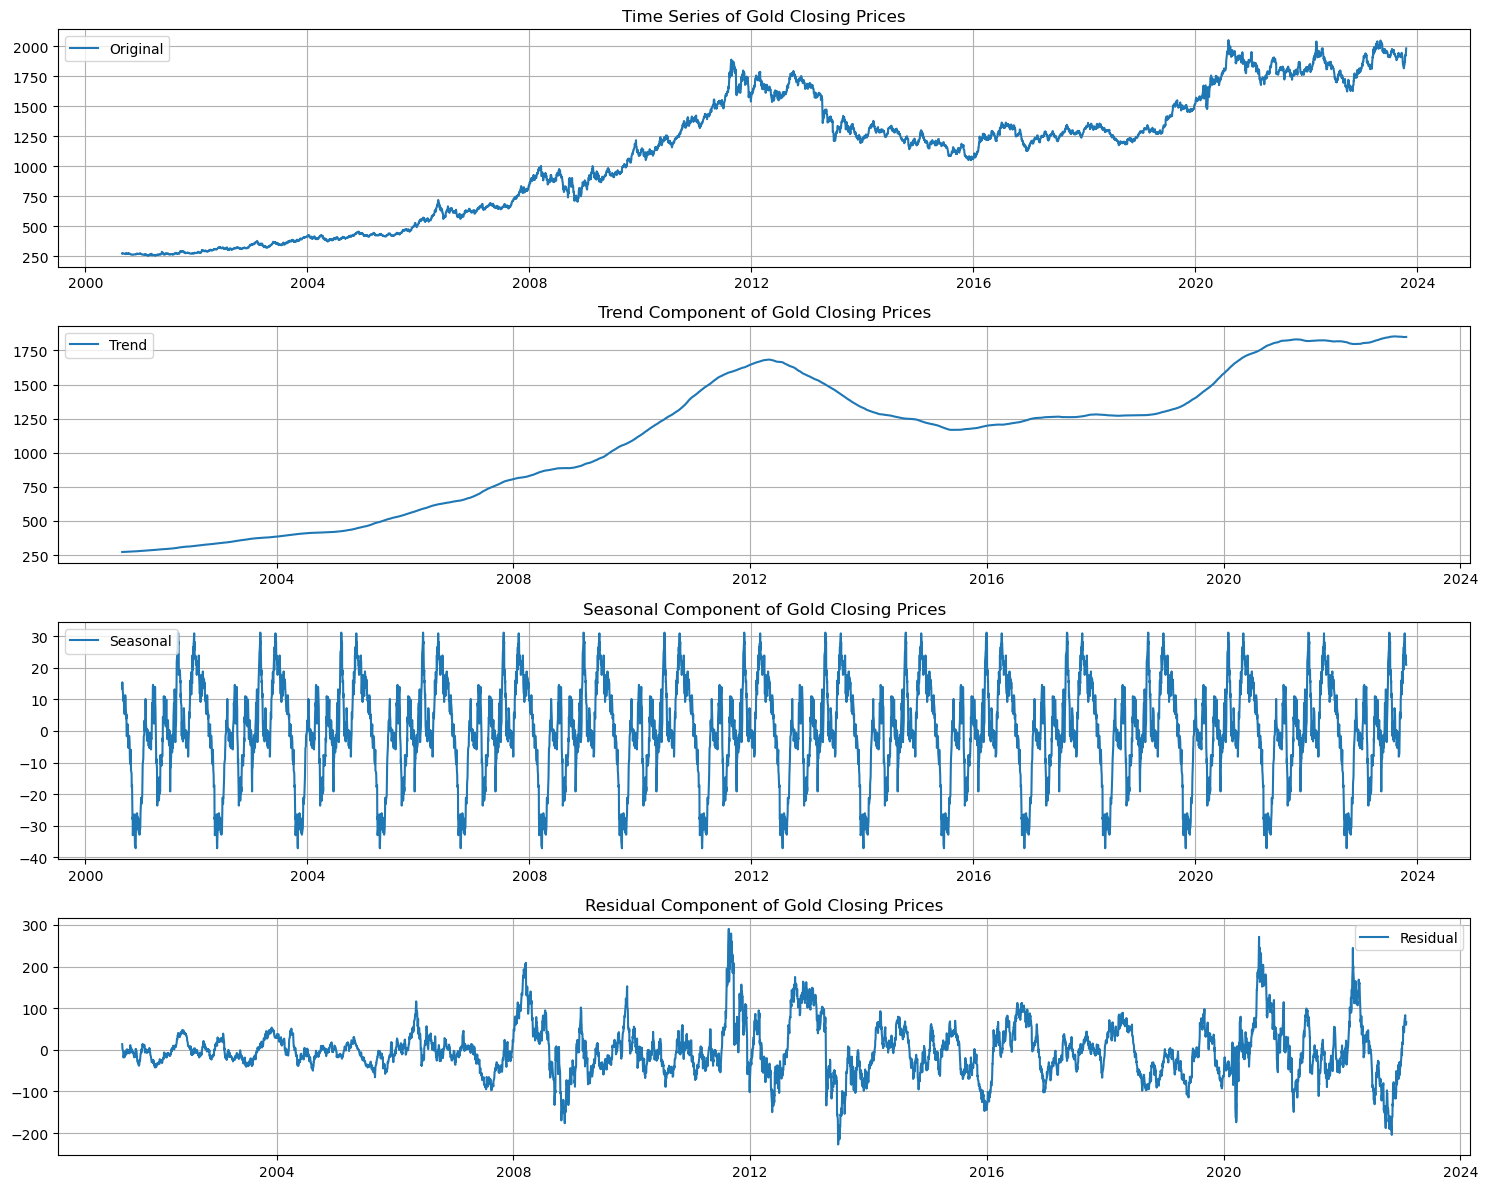

In [2]:
# Load the dataset (you'll need to modify the path if it's different)
commodities_data = pd.read_csv('Dataset/all_commodities_data.csv')

# Filter the dataset for Gold
gold_data = commodities_data[commodities_data['commodity'] == 'Gold']

# Convert the 'date' column to datetime format for better plotting
gold_data['date'] = pd.to_datetime(gold_data['date'])

# Decompose the time series data
decomposition = seasonal_decompose(gold_data['close'], model='additive', period=365)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))

# Original time series
ax1.plot(gold_data['date'], gold_data['close'], label='Original')
ax1.legend(loc='best')
ax1.set_title("Time Series of Gold Closing Prices")
ax1.grid(True)

# Trend component
ax2.plot(gold_data['date'], decomposition.trend, label='Trend')
ax2.legend(loc='best')
ax2.set_title("Trend Component of Gold Closing Prices")
ax2.grid(True)

# Seasonal component
ax3.plot(gold_data['date'], decomposition.seasonal, label='Seasonal')
ax3.legend(loc='best')
ax3.set_title("Seasonal Component of Gold Closing Prices")
ax3.grid(True)

# Residual component
ax4.plot(gold_data['date'], decomposition.resid, label='Residual')
ax4.legend(loc='best')
ax4.set_title("Residual Component of Gold Closing Prices")
ax4.grid(True)

plt.tight_layout()
plt.show()



C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\1620602536.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_data['date'] = pd.to_datetime(metal_data['date'])


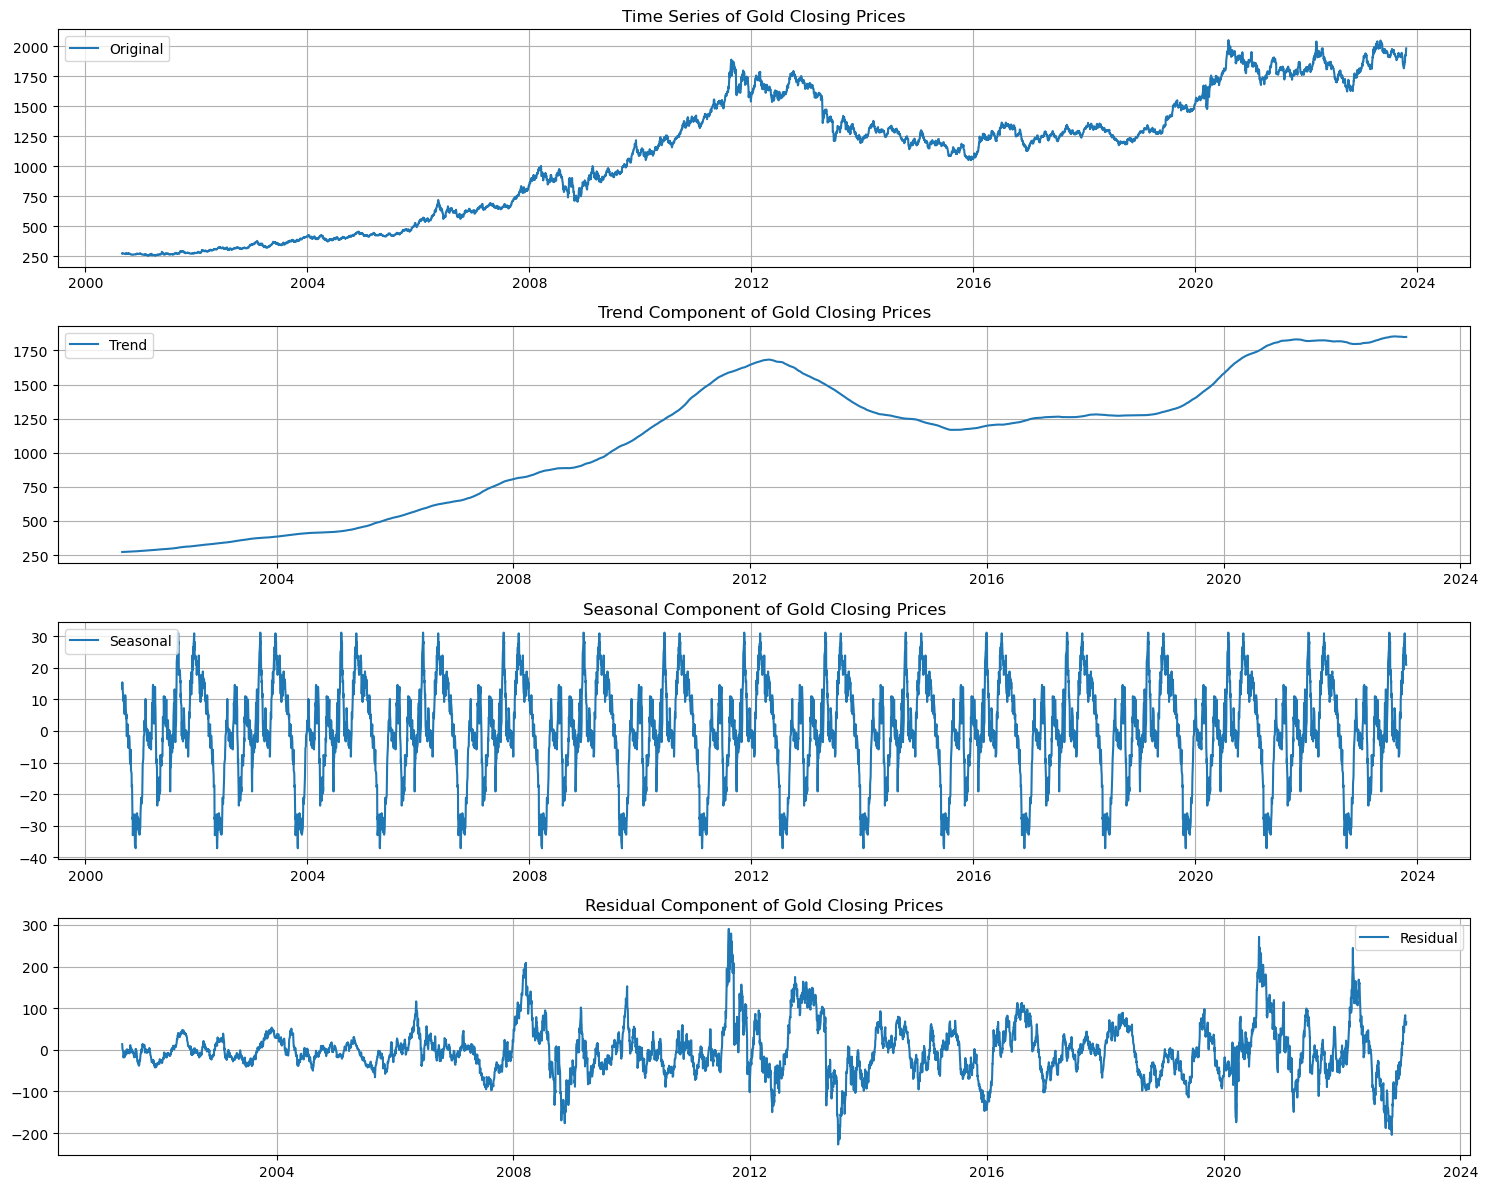

C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\1620602536.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_data['date'] = pd.to_datetime(metal_data['date'])


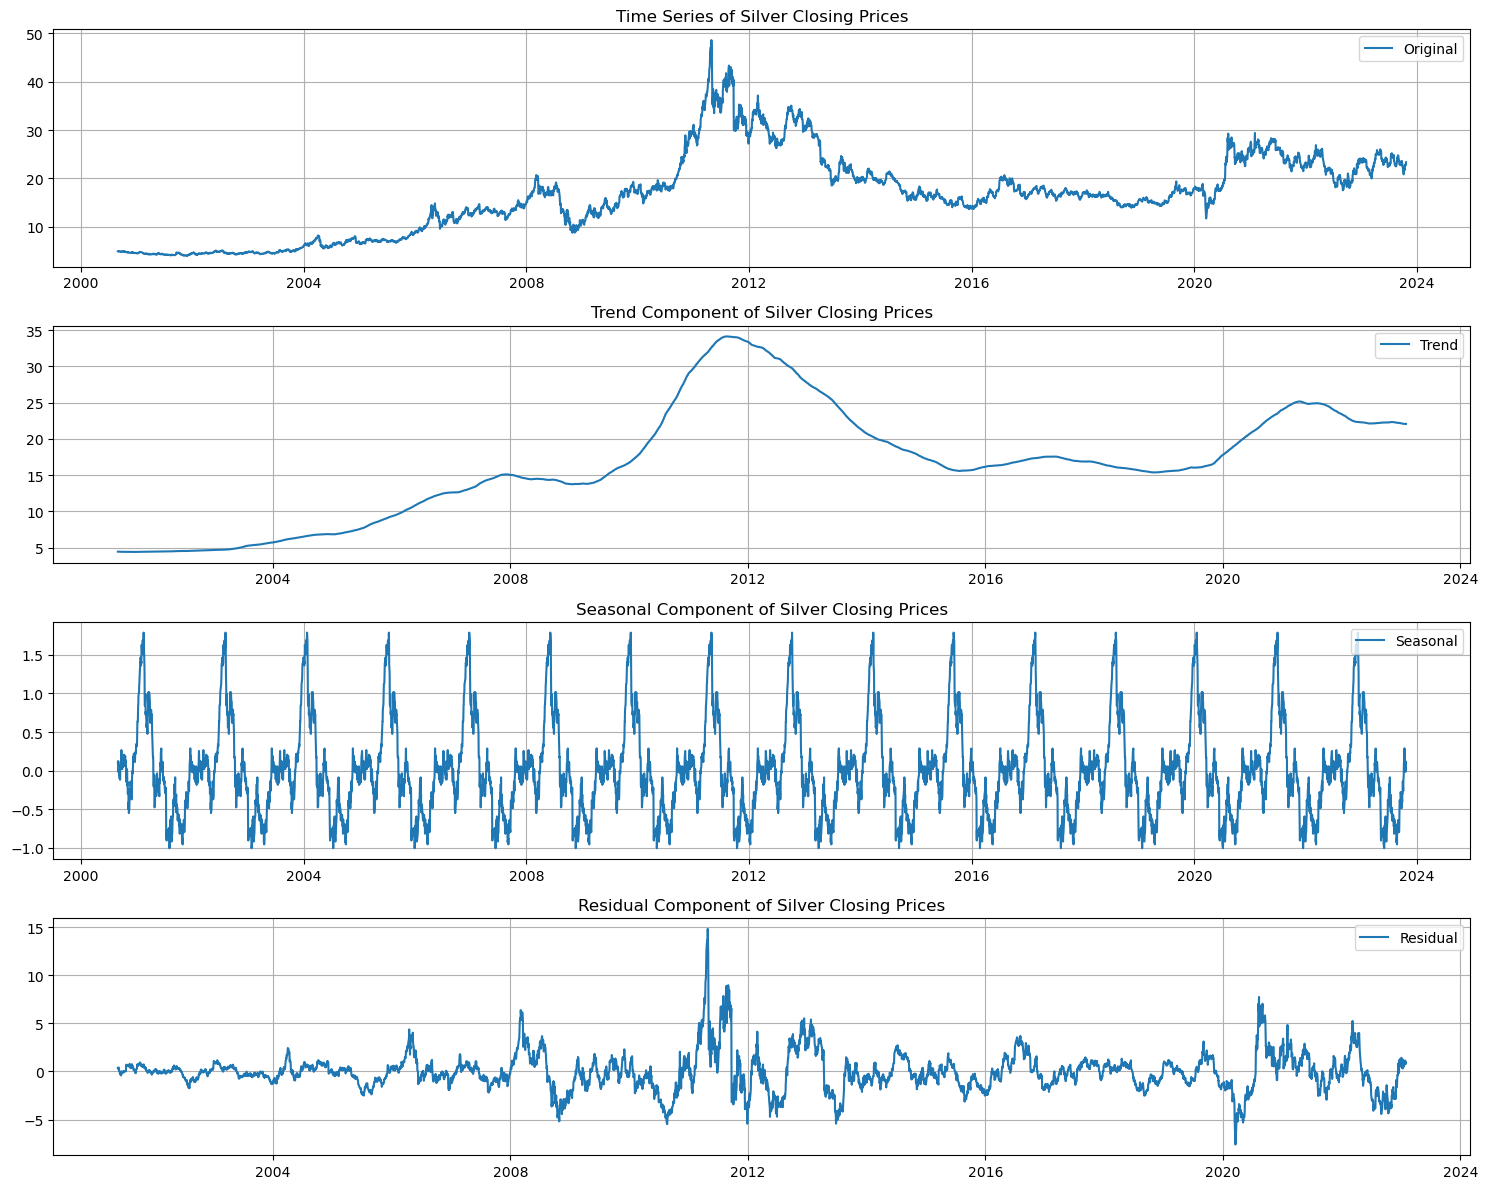

C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\1620602536.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_data['date'] = pd.to_datetime(metal_data['date'])


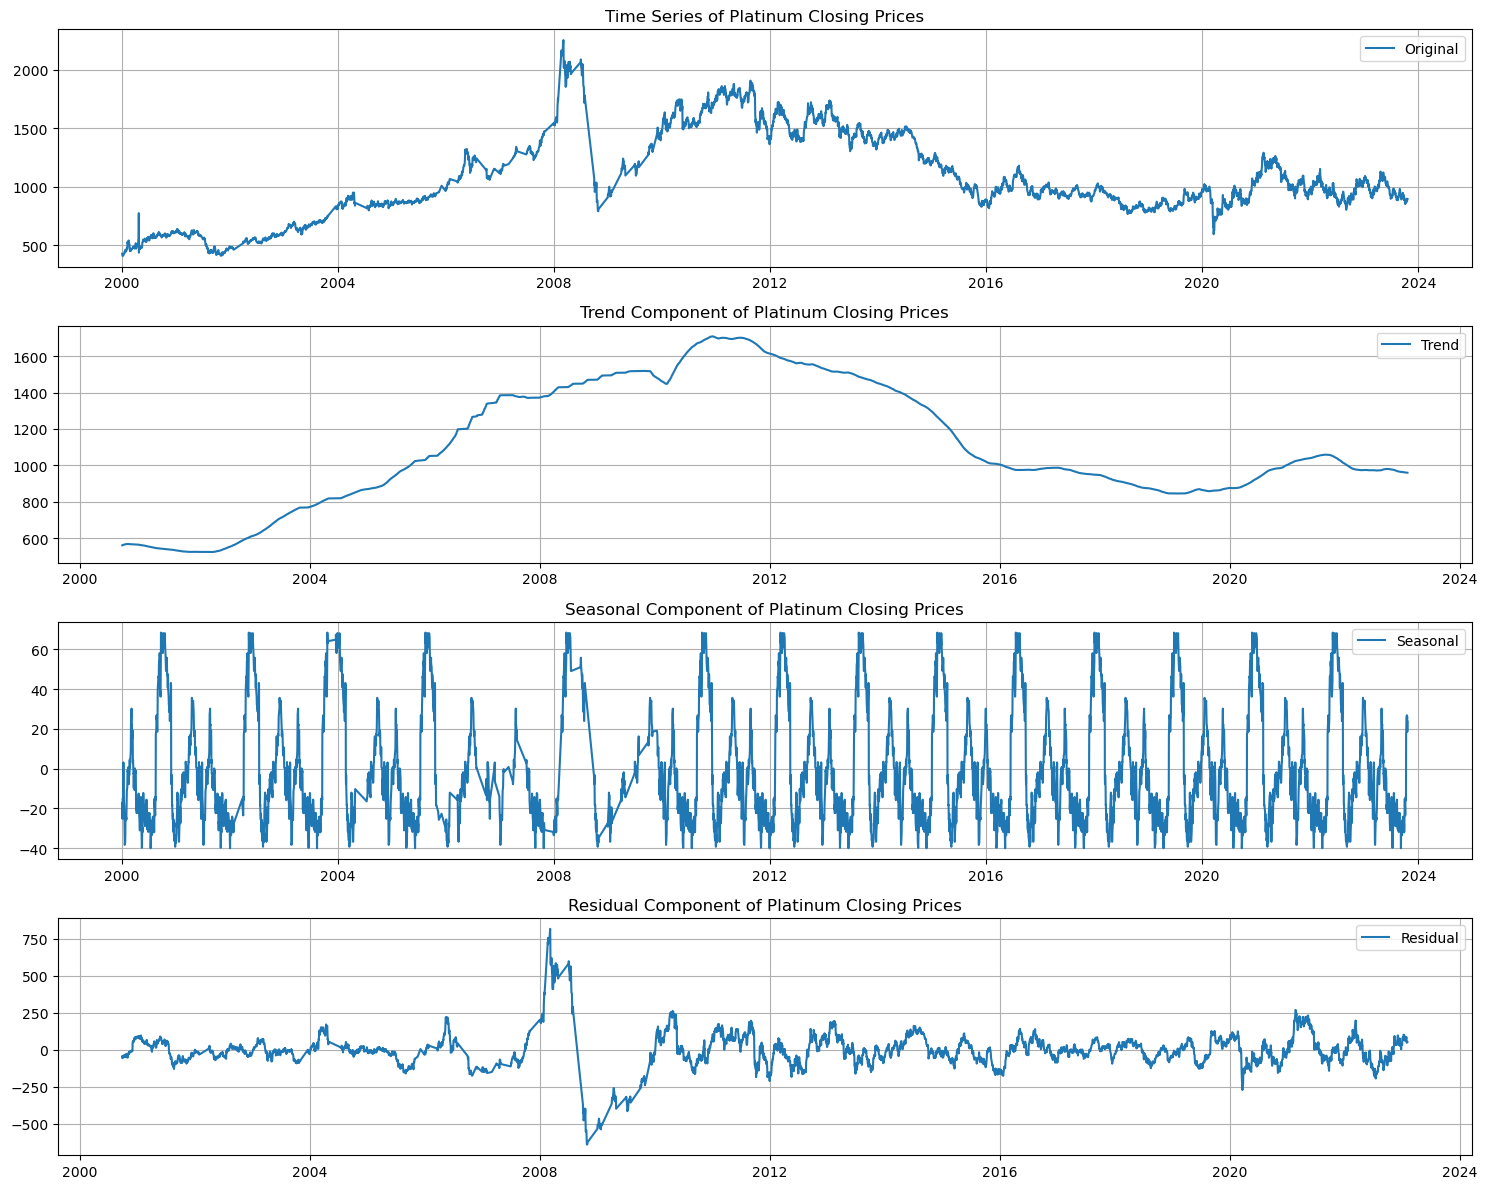

C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\1620602536.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_data['date'] = pd.to_datetime(metal_data['date'])


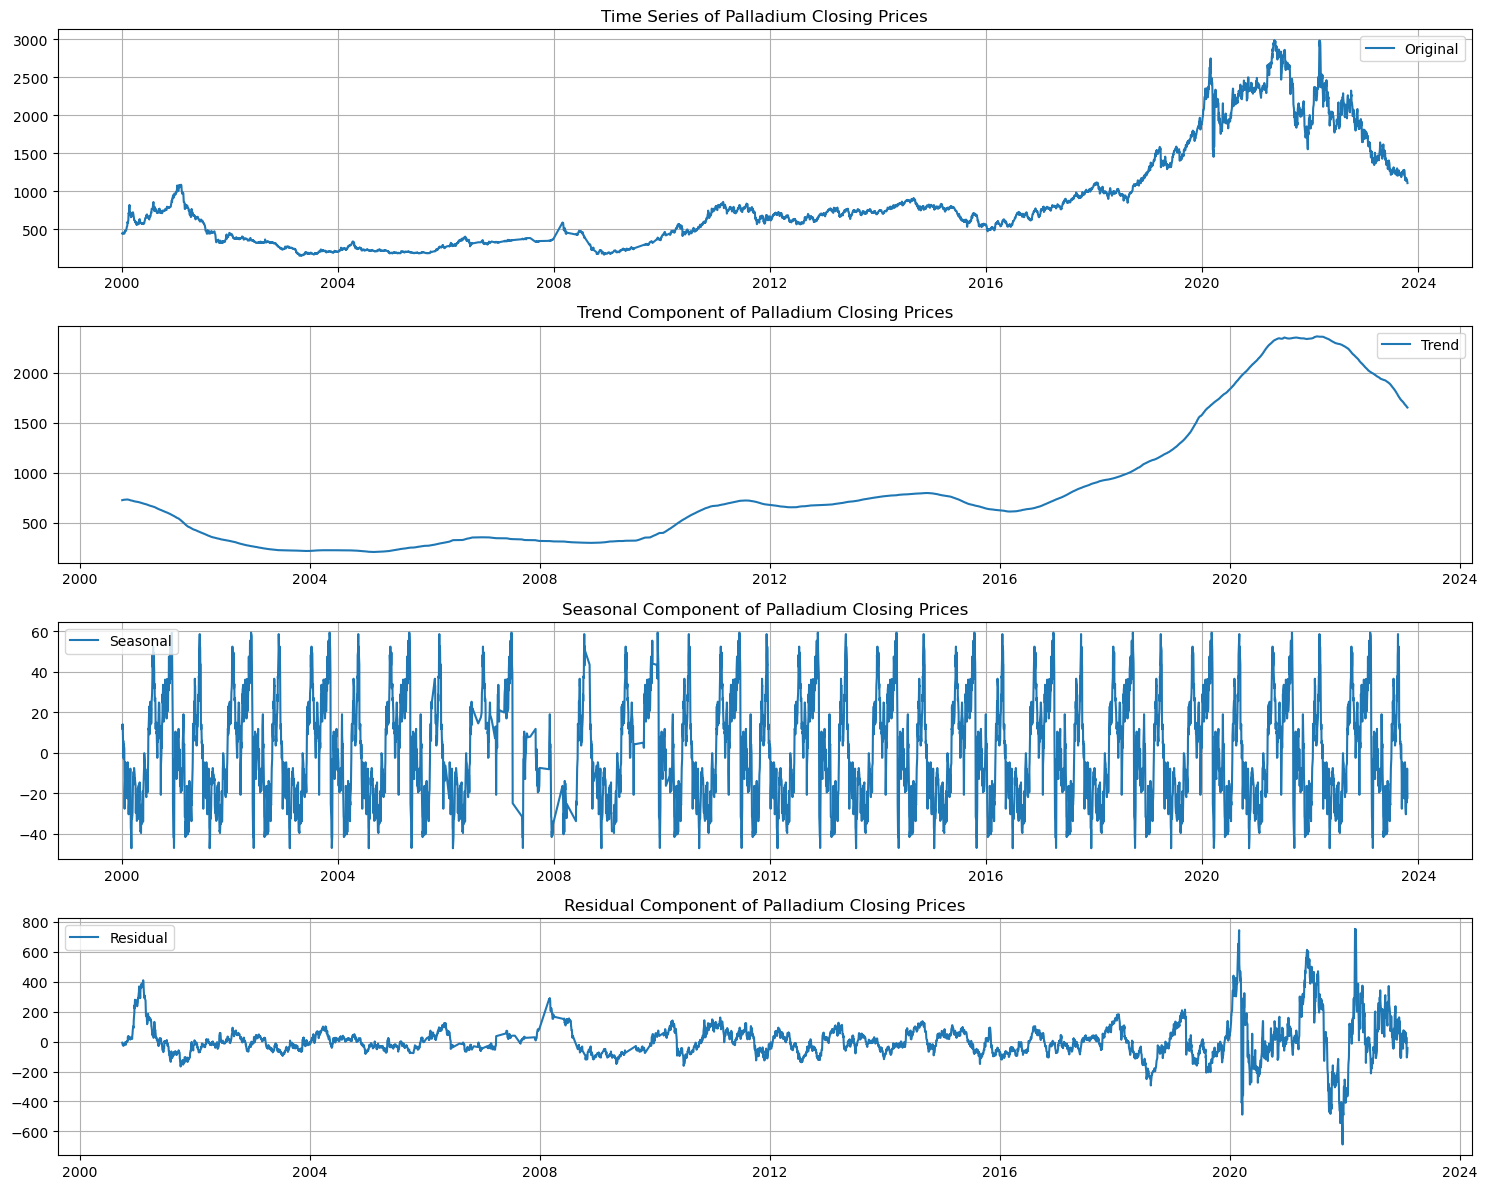

In [3]:
# Identify unique commodities in the dataset
unique_commodities = commodities_data['commodity'].unique()

# List of commonly known precious metals
precious_metals = ['Gold', 'Silver', 'Platinum', 'Palladium']

# Filter the unique commodities to identify those that are precious metals
precious_metals_in_dataset = [metal for metal in unique_commodities if metal in precious_metals]

precious_metals_in_dataset


# Function to decompose and visualize the time series for a given precious metal
def analyze_metal(metal_name, data):
    metal_data = data[data['commodity'] == metal_name]
    metal_data['date'] = pd.to_datetime(metal_data['date'])
    
    # Decompose the time series data
    decomposition = seasonal_decompose(metal_data['close'], model='additive', period=365)
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
    
    # Original time series
    ax1.plot(metal_data['date'], metal_data['close'], label='Original')
    ax1.legend(loc='best')
    ax1.set_title(f"Time Series of {metal_name} Closing Prices")
    ax1.grid(True)
    
    # Trend component
    ax2.plot(metal_data['date'], decomposition.trend, label='Trend')
    ax2.legend(loc='best')
    ax2.set_title(f"Trend Component of {metal_name} Closing Prices")
    ax2.grid(True)
    
    # Seasonal component
    ax3.plot(metal_data['date'], decomposition.seasonal, label='Seasonal')
    ax3.legend(loc='best')
    ax3.set_title(f"Seasonal Component of {metal_name} Closing Prices")
    ax3.grid(True)
    
    # Residual component
    ax4.plot(metal_data['date'], decomposition.resid, label='Residual')
    ax4.legend(loc='best')
    ax4.set_title(f"Residual Component of {metal_name} Closing Prices")
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

# Analyze each precious metal in the dataset
for metal in precious_metals_in_dataset:
    analyze_metal(metal, commodities_data)


C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\717701399.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_data['date'] = pd.to_datetime(metal_data['date'])


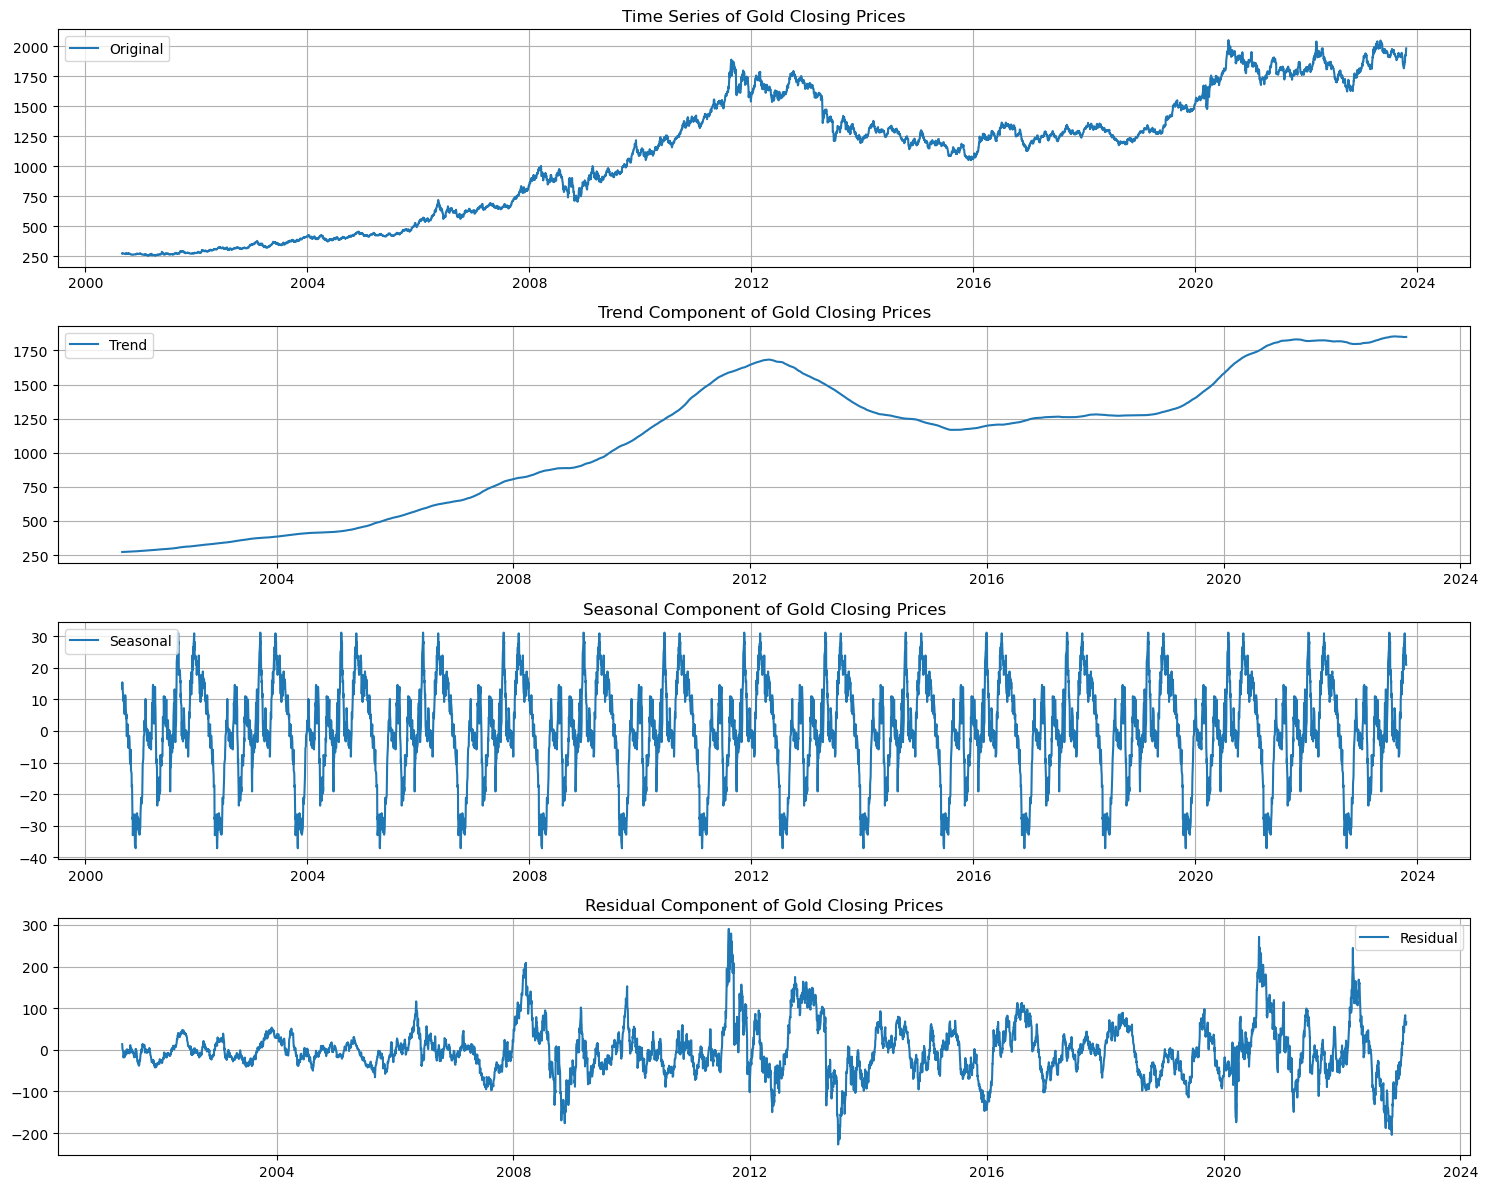

C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\717701399.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_data['date'] = pd.to_datetime(metal_data['date'])


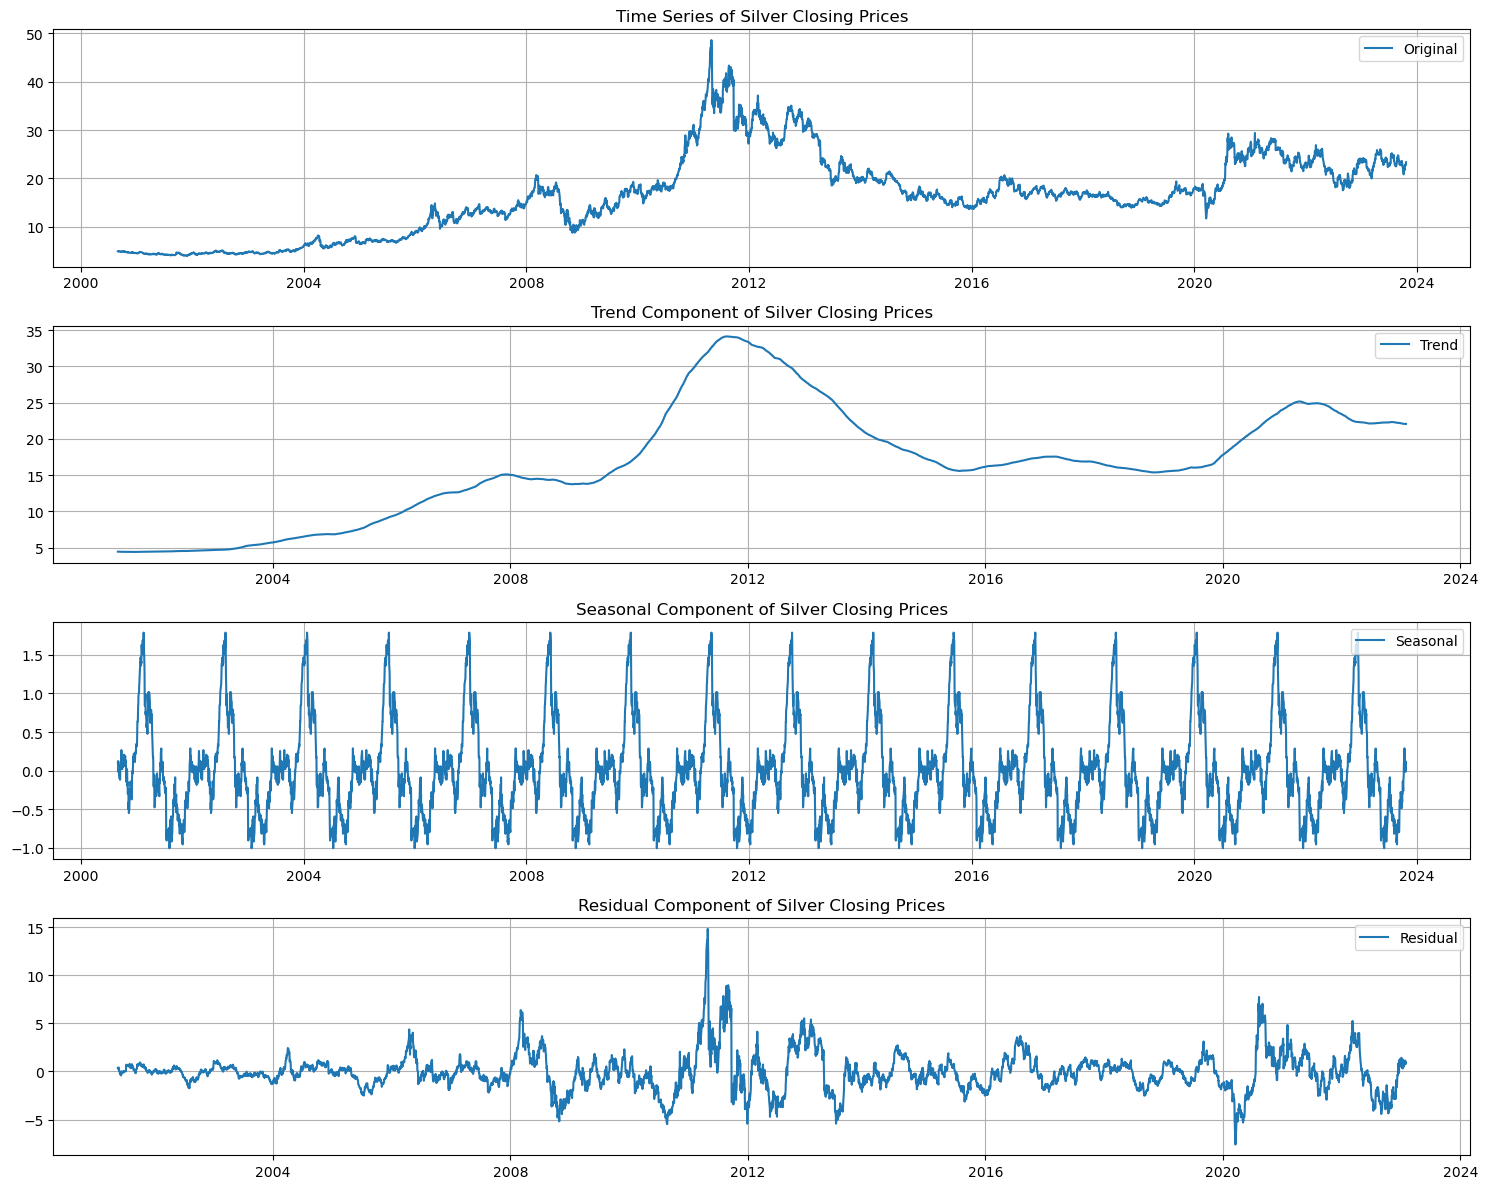

C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\717701399.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_data['date'] = pd.to_datetime(metal_data['date'])


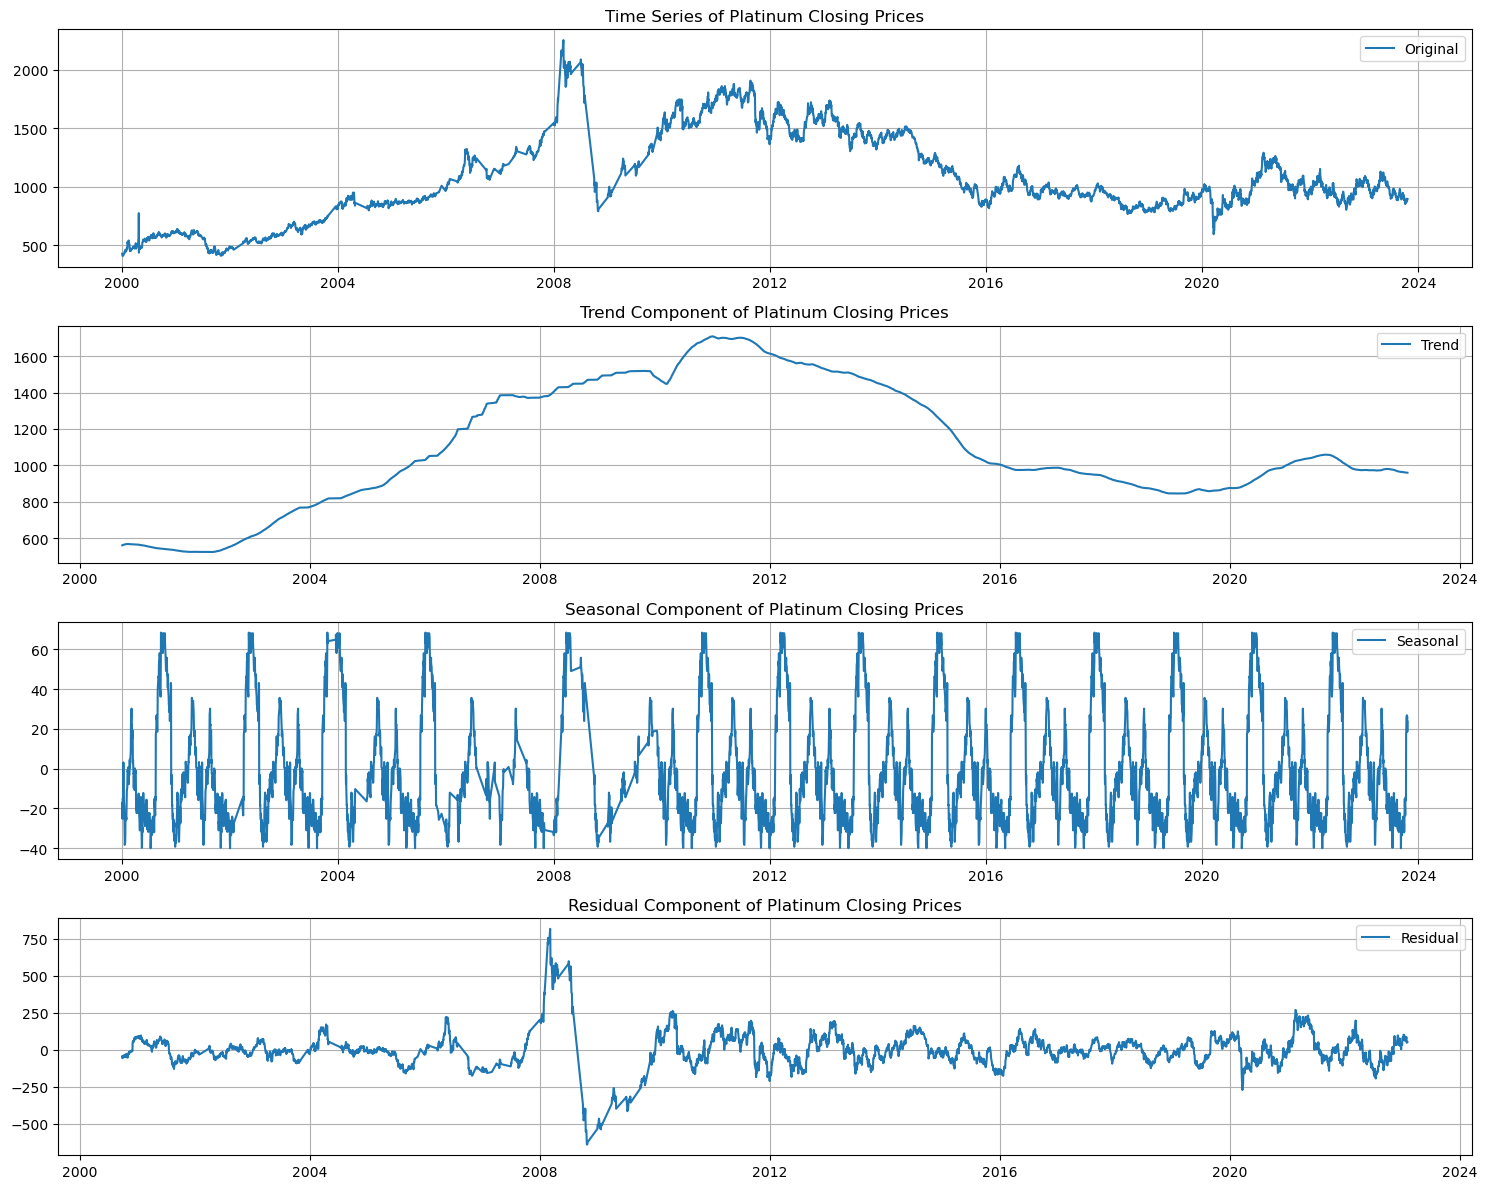

C:\Users\zhizh\AppData\Local\Temp\ipykernel_24420\717701399.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metal_data['date'] = pd.to_datetime(metal_data['date'])


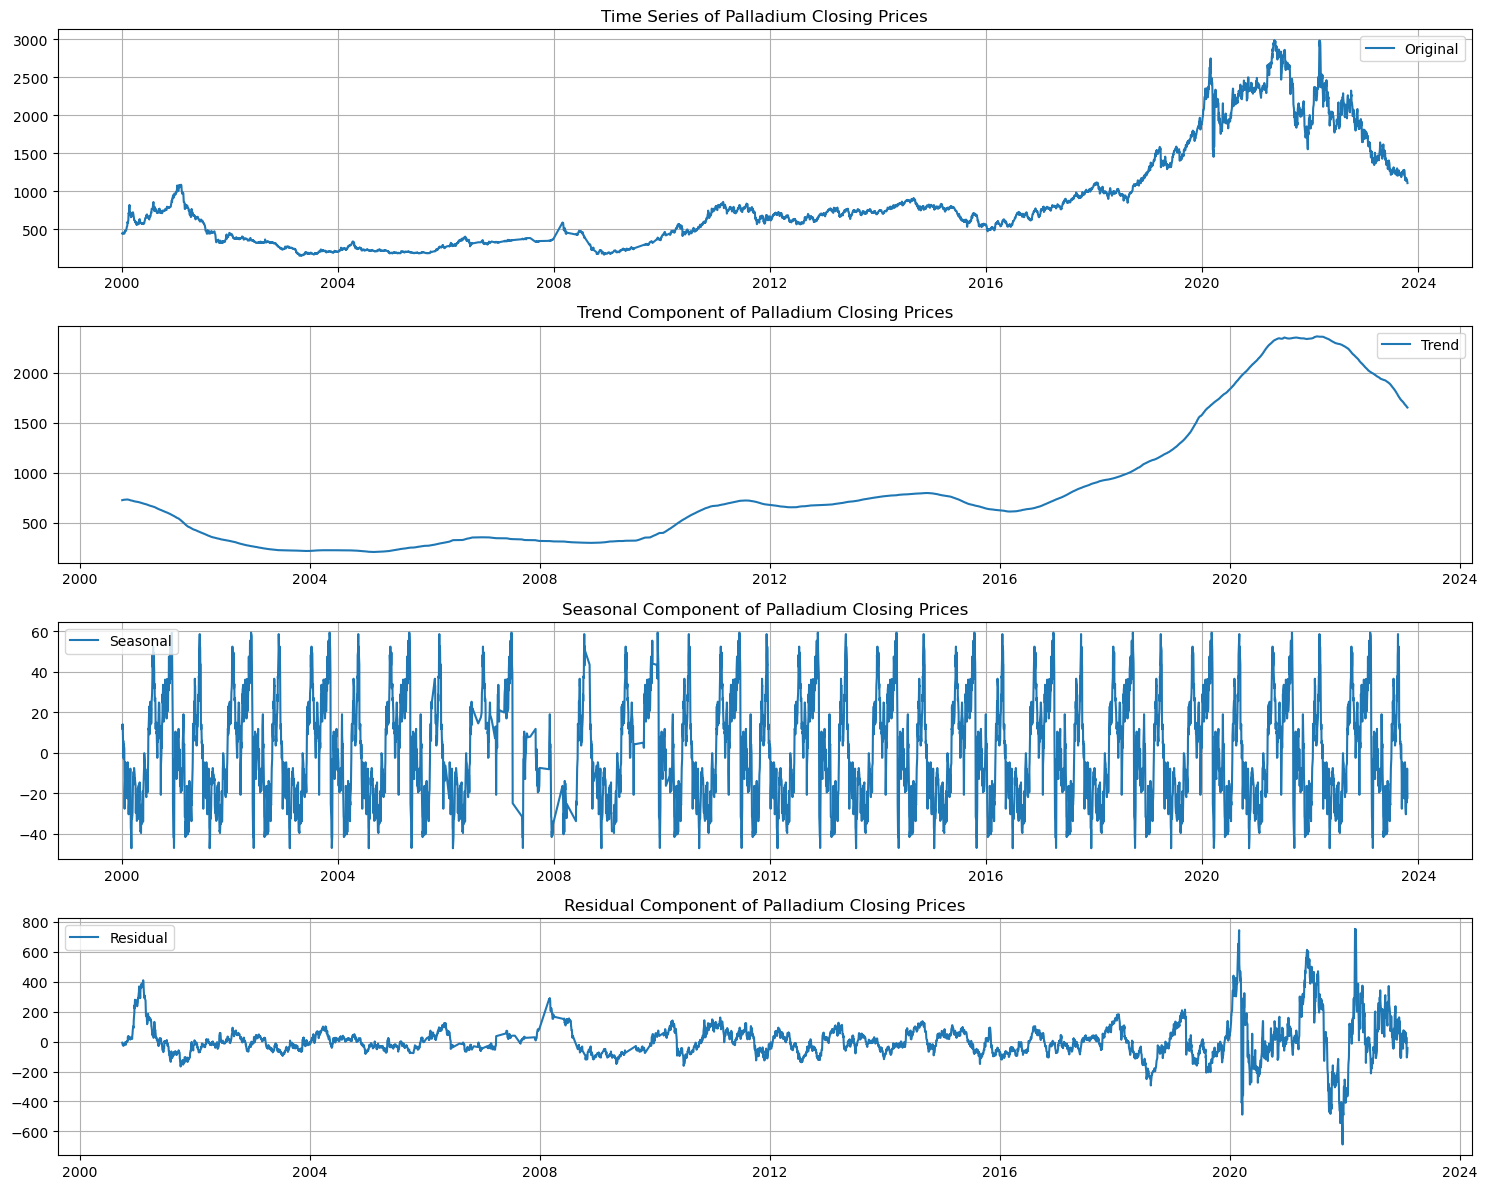

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load the dataset
commodities_data = pd.read_csv('Dataset/all_commodities_data.csv')

# Function to decompose and visualize the time series for a given precious metal
def analyze_metal(metal_name, data):
    metal_data = data[data['commodity'] == metal_name]
    metal_data['date'] = pd.to_datetime(metal_data['date'])
    
    # Decompose the time series data
    decomposition = seasonal_decompose(metal_data['close'], model='additive', period=365)
    
    # Plot the decomposed components
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 12))
    
    # Original time series
    ax1.plot(metal_data['date'], metal_data['close'], label='Original')
    ax1.legend(loc='best')
    ax1.set_title(f"Time Series of {metal_name} Closing Prices")
    ax1.grid(True)
    
    # Trend component
    ax2.plot(metal_data['date'], decomposition.trend, label='Trend')
    ax2.legend(loc='best')
    ax2.set_title(f"Trend Component of {metal_name} Closing Prices")
    ax2.grid(True)
    
    # Seasonal component
    ax3.plot(metal_data['date'], decomposition.seasonal, label='Seasonal')
    ax3.legend(loc='best')
    ax3.set_title(f"Seasonal Component of {metal_name} Closing Prices")
    ax3.grid(True)
    
    # Residual component
    ax4.plot(metal_data['date'], decomposition.resid, label='Residual')
    ax4.legend(loc='best')
    ax4.set_title(f"Residual Component of {metal_name} Closing Prices")
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

# List of commonly known precious metals
precious_metals = ['Gold', 'Silver', 'Platinum', 'Palladium']

# Analyze each precious metal in the dataset
for metal in precious_metals:
    analyze_metal(metal, commodities_data)


In [5]:
from sklearn.model_selection import train_test_split

# Extract the closing prices for Gold
gold_close_prices = gold_data[['date', 'close']].set_index('date')

# Split the data into training and test sets (80% train, 20% test)
train_data, test_data = train_test_split(gold_close_prices, test_size=0.2, shuffle=False)

train_data.head(), test_data.head()


(                 close
 date                  
 2000-08-30  273.899994
 2000-08-31  278.299988
 2000-09-01  277.000000
 2000-09-05  275.799988
 2000-09-06  274.200012,
                   close
 date                   
 2019-03-13  1307.500000
 2019-03-14  1293.400024
 2019-03-15  1301.800049
 2019-03-18  1300.300049
 2019-03-19  1305.000000)

In [6]:
# Set the frequency for the date index
train_data.index = pd.DatetimeIndex(train_data.index).to_period('D')
test_data.index = pd.DatetimeIndex(test_data.index).to_period('D')

# ARIMA Model
model_arima = ARIMA(train_data, order=(5,1,0))
model_arima_fit = model_arima.fit()
predictions_arima = model_arima_fit.forecast(steps=len(test_data))

# Evaluate ARIMA
mse_arima = mean_squared_error(test_data, predictions_arima)



In [7]:

# SARIMA Model
model_sarima = SARIMAX(train_data, order=(5,1,0), seasonal_order=(1,1,1,12))
model_sarima_fit = model_sarima.fit()
predictions_sarima = model_sarima_fit.forecast(steps=len(test_data))

# Evaluate SARIMA
mse_sarima = mean_squared_error(test_data, predictions_sarima)


In [15]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

import tensorflow as tf
np.random.seed(123)
tf.random.set_seed(123)

# Prepare data for LSTM
def prepare_data(data, lags=1):
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

lags = 3
X_train, y_train = prepare_data(train_data.values.reshape(-1,1), lags)
X_test, y_test = prepare_data(test_data.values.reshape(-1,1), lags)

# LSTM Model
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(lags, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=100, verbose=0)

predictions_lstm = model_lstm.predict(X_test)

# Evaluate LSTM
mse_lstm = mean_squared_error(y_test, predictions_lstm)


37/37 [==============================] - 0s 975us/step


In [16]:

mse_arima, mse_sarima, mse_lstm


(239213.66622242535, 125565.9559015526, 401.0662086429218)